# Postprocessing Model 1: Regex with keyword and data type 

**Auther**: Thuy Trinh

**Description**: <br>
This notebook outlines the work done on the first *postprocessing* model works, i.e: model that extract interested information from the text detected from GCV. The notebook includes 3 main versions of the model, i.e: Model 1.0, 1.1 and 1.2. Each is discussed in 3 steps:
1. Explain step-by-step how the model work
2. Compute accuracy of each model
3. Analyse model performance and outline possible future improvement

**Achievement**: <br>
Each version is improvement of previous one. <br>
Overall accuracy accross the 14 must-have fields are: <br>
**Model 1.0**: 0.468 <br>
**Model 1.1**: 0.502 <br>
**Model 1.2**: 0.573 <br>

## Import packages

In [221]:
%load_ext autoreload
%autoreload 2
## load packages
from exploration.src_thuy.ocr_base.display.display import Display
from exploration.src_thuy.ocr_insurance_card.text_processing.config_postprocess import hint_dict, interested_fields, data_type_regex
from exploration.src_thuy.ocr_base.accuracy.metric import Metric
from exploration.src_thuy.ocr_insurance_card.text_processing.regex import PostprocessRegex as PR
from IPython.display import display
from jupyter_helpers.namespace import NeatNamespace 
import numpy as np
import re
import cv2
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data
Data taken from saved file from previous work, nothing change

In [222]:
# path to folder contains images
image_dir = "/Users/thuyttt/OneDrive - MTI/AILab/06_Data/ocr_insurance_cards/raw/images"

In [223]:
from exploration.src_thuy.ocr_insurance_card.pipeline.load_data import *

# Methods

## Model 1.0: Baseline model - Regex with keyword and data type
Simple logic: the output information would be in the form: `keyword + space + data_in_a_pre-defined_form` 

We can create a "hint" dictionary that contains 2 things:
1. all keywords 
2. data type of all the fields that need extracting

Then create a regular expression that match the pattern: `keyword + space + data_in_a_pre-defined_form`

The hint dictionary is displayed below

In [224]:
Display.display_dict_nb(hint_dict, transpose=True)

keyword                 type
Dependent                            [本人, 家族, 被保険者]  dependent_word_form
Symbol                                           記号               number
Number                                           番号               number
Name                                             氏名          person_name
NameKatakana                                   フリガナ        name_katakana
Sex                                              性別                  sex
Birthday                                       生年月日                 date
AcquisitionDate                    [資格取得年月日, 認定年月日]                 date
IssueDate                               [交付年月日, 交付]                 date
InsuredPersonName            [組合員氏名, 被保険者氏名, 世帯主氏名]          person_name
ExpireDate                                     有効期限                 date
Address                                          住所              address
WorkplaceName                                 事業所名称                 word
WorkplaceAddress                             事業所所在地              address
WorkplacePhoneNo                            事業所電話番号             phone_no
InsurerName                                   保険者名称                 word
IssuerAddress                                保険者所在地              address
IssuerPhoneNo                               保険者電話番号             phone_no
InsuranceNumber    [保険者番号, 約番号名称, 金賞者番号名称, 保険者番号名称]       8_digit_number

In [184]:
data_type_regex

{'number': '\\d{3,}',
 'date': '\\w{2}?\\d{2}年\\s?\\d{1,2}月\\d{1,2}日',
 'phone_no': '\\d{2,3}-\\d{3,4}-\\d{4}',
 'person_name': '([^年月日\\W\\d]){1,3}\\s?([^年月日\\W\\d]){1,3}',
 'sex': '男|女',
 'address': '(\\w*)(町\\d+-\\d+-\\d+)',
 'dependent_word_form': '((本人|家族)(\\s*)(\\(\\s*被保険者\\s*\\))?)',
 '8_digit_number': '\\d{8}',
 'name_katakana': '([ぁ-んァ-ン]{1,3}?\\s?[ぁ-んァ-ン]{1,4})'}

### Step-by-step procedure

#### Extract information for one field "Symbol"

In [185]:
def display_img(img_name):
    img_extension = gcv_res_dict[img_name]["extension"]
    img_path = image_dir + "/" + img_name + img_extension
    img = cv2.imread(img_path, 1)
    Display.display_img_nb(img)

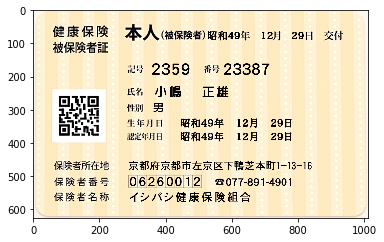

In [186]:
img_name = "01"
display_img(img_name)

In [187]:
raw_text = gcv_text_dict[img_name]
print("raw_text:\n", raw_text)

raw_text:
 健康保険本人(被保険者) 昭和49年 12月29日 交付
被保険者証
記号 2359 番号 23387
氏名 小嶋 正雄
性別 男
生年月日 昭和49年 12月29日
認定年月日 昭和49年12月29日
に
保険者所在地
保険者番号
保険者名称
京都府京都市左京区下鴨芝本町1-13-16
06260012 8077-891-4901
イシバシ健康保険組合



In [294]:
# reform text by concating texts of seperate lines into one single string
reformed_text = PR.gcv_text_reform(text=raw_text)
print("reformed_text: \n", reformed_text)

reformed_text: 
  健康保険本人(被保険者) 昭和 53 年 12 月 23 日 交付 被保険者証記号 1764番号 42377 性別 女 アリタリカ 氏名 有田 梨加 生年月日 昭和53年12月23日 資格取得年月日 昭和53年12月23日 事業所所在地 長野県長野市鬼無里日下野4-10 事業所名称 株式会社武藤コーポレーション 保険者所在地 青森県西津軽郡深浦町松神4-11-20 保険者番号・名称 06 0:24:269| 上がりながらがっている。キタジマ健康保険組合 017 (278) 3493


In [295]:
# generate regular expression from a given keyword and data type for field "Number"

## generate regular expression for an output of a given data type:
def data_type_to_regex(data_type):
    """
    generate regex for different data type
    return any Alphanumeric characters as default value if none of the pre-defined type matched

    @para
    data_type: a string that defines type of data

    @retun
    corresponding regex
    """
    switcher = data_type_regex

    return switcher.get(data_type, "([^年月日\W\d])*")

In [296]:
## generate regex from keyword and output_type
def regex_gen(keywords, output_type):
    """
    generate regex from keyword and output_type
    simple logic: keyword + space + regex of output_type

    @para
    keyword: can be a single word or a vectors of multiple keywords in string form
    output_type: a string that defines output type
    keyword_need: apply for the case of 

    @return
    corresponding regex
    """
    output_type_regex = data_type_to_regex(output_type)
    
    # if there are more than 1 keyword,
    # concat them into on string with character "|" as seperation
    if isinstance(keywords, list):
        keyword = keywords[0]
        for key in keywords[1:]:
            keyword = keyword + "|" + key
    else:
        keyword = keywords

    pattern = "(?P<keyword>" + keyword + ")" + "(\s*)" + "(?P<output>" + output_type_regex + ")"

    regex = re.compile("{}".format(pattern))
    return regex

In [297]:
keywords = hint_dict["Symbol"]["keyword"]
data_type = hint_dict["Symbol"]["type"]

print("keywords:", keywords)
print("data_type:", data_type)
print("generated regex for the given data_type:", data_type_to_regex(data_type=data_type))
print("generated regex for information extraction from keyword and data_type:\n", regex_gen(keywords=keywords, output_type=data_type))

keywords: 記号
data_type: number
generated regex for the given data_type: \d{3,}
generated regex for information extraction from keyword and data_type:
 re.compile('(?P<keyword>記号)(\\s*)(?P<output>\\d{3,})')


In [298]:
# apply extraction regex to the reformed text
regex = regex_gen(keywords=keywords, output_type=data_type)
text = reformed_text

x = re.search(regex, text)
pred = float("NaN")
if x:
    print("found match! \n matched text:", x.group())
    print("output:", x.group("output"))
    output = x.group("output")
    # remove space inside output:
    output = re.sub("\s", "", output)
    if len(output) > 0:
        pred = output
else:
    print("No match found!")

found match! 
 matched text: 記号 1764
output: 1764


#### Extract all interested fields for one image

In [299]:
def regex_search(regex, text):
    x = re.search(regex, text)
    pred = float("NaN")
    if x:
        output = x.group("output")
        # remove space inside output:
        output = re.sub("\s", "", output)
        if len(output) > 0:
            pred = output
    return pred

print("text:\n", reformed_text)
pred = {f: float("nan") for f in interested_fields}
for field in interested_fields:
#     print("Field:", field)
    keywords = hint_dict[field]["keyword"]
    data_type = hint_dict[field]["type"]
#     print("keywords:\n", keywords)
#     print("data_type:\n", data_type)
    
    data_type_reg = data_type_to_regex(data_type=data_type)
#     print("generated regex for the given data_type:\n", data_type_reg)
    regex = regex_gen(keywords=keywords, output_type=data_type)
#     print("generated regex for information extraction from keyword and data_type:\n", regex)
    
#     print("\n Searching through the text for string that matches interested pattern:")
    pred[field] = regex_search(regex, reformed_text)
#     print("==========================")
print("final result:")
pred

text:
  健康保険本人(被保険者) 昭和 53 年 12 月 23 日 交付 被保険者証記号 1764番号 42377 性別 女 アリタリカ 氏名 有田 梨加 生年月日 昭和53年12月23日 資格取得年月日 昭和53年12月23日 事業所所在地 長野県長野市鬼無里日下野4-10 事業所名称 株式会社武藤コーポレーション 保険者所在地 青森県西津軽郡深浦町松神4-11-20 保険者番号・名称 06 0:24:269| 上がりながらがっている。キタジマ健康保険組合 017 (278) 3493
final result:


{'Dependent': nan,
 'InsuranceNumber': nan,
 'Symbol': '1764',
 'Number': '42377',
 'Name': '有田梨加',
 'NameKatakana': nan,
 'Sex': '女',
 'Birthday': '昭和53年12月23日',
 'AcquisitionDate': '昭和53年12月23日',
 'InsuredPersonName': nan,
 'ExpireDate': nan,
 'InsurerName': nan,
 'IssuerAddress': nan,
 'IssuerPhoneNo': nan,
 'IssueDate': nan,
 'Address': nan,
 'WorkplaceName': '株式会社武藤コーポレーション',
 'WorkplaceAddress': nan,
 'WorkplacePhoneNo': nan}

#### Compare with the correct result

In [300]:
def merge_pred_target_dict(pred, tar):
    pred_df = pd.DataFrame(list(pred.items()), columns=["Fields", "Predict"])
    tar_df = pd.DataFrame(list(tar.items()), columns=["Fields", "Correct"])
    result = pd.merge(pred_df, tar_df, on="Fields", how="left")
    return result

In [301]:
def merge_res_error_dict(res, err):
    ler_list = []
    discrete_list = []
    for k in list(err.keys()):
        ler_list.append(1 - err[k]["ler"])
        discrete_list.append(1 - err[k]["discrete"])
        
    err_dict = {"Fields": list(err.keys()),
                "Discrete Accuracy": discrete_list,
                "Levenstein Accuracy": ler_list}
    err_df = pd.DataFrame.from_dict(err_dict)
    res_with_accu = pd.merge(res, err_df, on="Fields", how="left")
    return res_with_accu

In [302]:
tar = label_dict[img_name]
merge_pred_target_dict(pred, tar)

Fields         Predict              Correct
0           Dependent             NaN             本人(被保険者)
1     InsuranceNumber             NaN             06024269
2              Symbol            1764                 1764
3              Number           42377                42377
4                Name            有田梨加                 有田梨加
5        NameKatakana             NaN                アリタリカ
6                 Sex               女                    女
7            Birthday     昭和53年12月23日          昭和53年12月23日
8     AcquisitionDate     昭和53年12月23日          昭和53年12月23日
9   InsuredPersonName             NaN                  NaN
10         ExpireDate             NaN                  NaN
11        InsurerName             NaN           キタジマ健康保険組合
12      IssuerAddress             NaN  青森県西津軽郡深浦町松神4-11-20
13      IssuerPhoneNo             NaN         017-278-3493
14          IssueDate             NaN          昭和53年12月23日
15            Address             NaN                  NaN
16      WorkplaceName  株式会社武藤コーポレーション       株式会社武藤コーポレーション
17   WorkplaceAddress             NaN     長野県長野市鬼無里日下野4-10
18   WorkplacePhoneNo             NaN                  NaN

### Model 1.0 performance analysis

Firstly, the model could not find `Dependent`, `InsuranceNumber`, `IssuerAddress`, `IssuerPhoneNo` and `IssueDate`. 

This is due to two reasons:
1. The keywords do not lie in the same line with the output in the text returned by gcv. These are the case for fields `InsuranceNumber` and`IssuerAddress`. For instance, we have the keywords for those fields inside the text, which are: `保険者番号`, `保険者名称`, but they do not appear in the same line with our next to the their corresponding values. Rather, they separates like below:

        保険者所在地 
        保険者番号
        保険者名称 
        京都府京都市左京区下鴨芝本町1-13-16
        06260012 8077-891-4901
        イシバシ健康保険組合


2. The field does not have keyword in front of it, as in the case of `Dependent` and `IssuerPhoneNo`. Also, in the case of `IssueDate`, the keyword `交付` is displayed behide the value of the date., like this `昭和49年 12月29日 交付`

Secondly, the model misclassified the value of the field `IssuerAddress` as `InsurerName`. This is because the keyword of `InsurerName`, i.e: `保険者名称` is present right in front of the value for `IssuerAddress`, i.e: `京都府京都市左京区下鴨芝本町1-13-16`, and our regex for for `InsurerName` is to take Japanese words after the keyword `保険者名称`, hence the misclassified.

### Overall accuracy for Model 1.0

In [303]:
# wrap everything into one function
def get_pred_dict_1_0(raw_gcv_long_text):
    """
    this function wrap-up all the steps done above in the Model 1.0 
    into one single function
    """
    reformed_text = PR.gcv_text_reform(raw_gcv_long_text)
    
    def regex_search(regex, text):
        x = re.search(regex, text)
        pred = float("NaN")
        if x:
            output = x.group("output")
            # remove space inside output:
            output = re.sub("\s", "", output)
            if len(output) > 0:
                pred = output
        return pred

    pred = {f: float("nan") for f in interested_fields}
    for field in interested_fields:
        keywords = hint_dict[field]["keyword"]
        data_type = hint_dict[field]["type"]

        data_type_reg = data_type_to_regex(data_type=data_type)
        regex = regex_gen(keywords=keywords, output_type=data_type)
        pred[field] = regex_search(regex=regex, text=reformed_text)
    
    return pred

In [304]:
img_name = "02"
raw_gcv_long_text = gcv_res_dict[img_name]["full_text"][0]
print(raw_gcv_long_text)
get_pred_dict_1_0(raw_gcv_long_text)

健康保険 本人(被保険者)昭和37年 10月 23日 交付
被保険者証
記号 8788 番号 19826
氏名 雨宮真凛
性別 女
生年月日 昭和37年10月23日
102 23
認定年月日 昭和37年10月23日
保険者所在地 神奈川県川崎市宮前区犬蔵2-20-1
保険者番号 06 140 024 80466-56-6450
保険者名称 バン健康保険組合



{'Dependent': nan,
 'InsuranceNumber': nan,
 'Symbol': '8788',
 'Number': '19826',
 'Name': '雨宮真凛',
 'NameKatakana': nan,
 'Sex': '女',
 'Birthday': '昭和37年10月23日',
 'AcquisitionDate': '昭和37年10月23日',
 'InsuredPersonName': nan,
 'ExpireDate': nan,
 'InsurerName': 'バン健康保険組合',
 'IssuerAddress': nan,
 'IssuerPhoneNo': nan,
 'IssueDate': nan,
 'Address': nan,
 'WorkplaceName': nan,
 'WorkplaceAddress': nan,
 'WorkplacePhoneNo': nan}

In [305]:
def compute_accuracy_multiple_imgs(prediction_method):
    numb_fields = len(interested_fields)
    lev_accu = np.zeros(numb_fields)
    discrete_accu = np.zeros(numb_fields)
    for key in list(label_dict.keys()):
        img_name = key
#         print("img_name", img_name)
#         reform_texts = text_reform_method(gcv_res_dict[img_name]['full_text'][0])
#         pred = prediction_method(text=reform_texts, hint_dict=hint_dict, fields=interested_fields)
        raw_gcv_long_text = gcv_res_dict[img_name]["full_text"][0]
        pred = prediction_method(raw_gcv_long_text)
#         print("pred:", pred)
        tar = label_dict[img_name]
        err = Metric.err_rate(pred, tar)
#         print("err", err)
        tmp_lev_accu = []
        tmp_discrete_accu = []
        for k in list(err.keys()):
            tmp_lev_accu.append(1 - err[k]["ler"])
            tmp_discrete_accu.append(1 - err[k]["discrete"])
#         print("tmp_lev_accu", tmp_lev_accu)
#         print("tmp_discrete_accu", tmp_discrete_accu)
        lev_accu = lev_accu + np.array(tmp_lev_accu)
        discrete_accu = discrete_accu + np.array(tmp_discrete_accu)
        
#     print("lev_accu", lev_accu)
#     print("discrete_accu", discrete_accu)
    # averaging the accuracy by the number of images
    numb_keys = len(list(label_dict.keys()))
    lev_accu = lev_accu/numb_keys
    discrete_accu = discrete_accu/numb_keys

    # create an accuracy table for display and store the result
    accu_dict = {"Fields": list(err.keys()),
                 "Discrete Accuracy": discrete_accu,
                 "Levenstein Accuracy": lev_accu,}
    accu_df = pd.DataFrame.from_dict(accu_dict)
    return accu_df

In [306]:
accuracy_df = compute_accuracy_multiple_imgs(prediction_method=get_pred_dict_1_0)
must_have_fields = ["Dependent", "InsuranceNumber", "Symbol", "Number", "Name", "NameKatakana",
                   "Sex", "Birthday", "InsuredPersonName", "ExpireDate", "InsurerName", "IssuerAddress", "IssuerPhoneNo"]
overall_accuracy_must_have_fields = sum(accuracy_df["Discrete Accuracy"][0:13])/14
print("overall_accuracy_must_have_fields:", overall_accuracy_must_have_fields)
accuracy_df.round(2)

overall_accuracy_must_have_fields: 0.4684285714285714


Fields  Discrete Accuracy  Levenstein Accuracy
0           Dependent               0.20                 0.20
1     InsuranceNumber               0.26                 0.31
2              Symbol               0.63                 0.65
3              Number               0.59                 0.60
4                Name               0.57                 0.67
5        NameKatakana               0.37                 0.37
6                 Sex               0.71                 0.71
7            Birthday               0.56                 0.58
8     AcquisitionDate               0.44                 0.45
9   InsuredPersonName               0.83                 0.84
10         ExpireDate               0.74                 0.75
11        InsurerName               0.37                 0.38
12      IssuerAddress               0.28                 0.29
13      IssuerPhoneNo               0.36                 0.36
14          IssueDate               0.13                 0.13
15            Address               0.79                 0.79
16      WorkplaceName               0.78                 0.80
17   WorkplaceAddress               0.73                 0.73
18   WorkplacePhoneNo               1.00                 1.00

The field `WorkplacePhoneNo` have accuracy of `1.0` due to the fact the all of the data in this field is missing, hence, our Model achieves accuracy of `1.0` by assinging value of `nan` for this field

### Improvement approaches

There are two approaches to solve the above issue:
1. Reform the raw text returned by gcv by matching words of the same line into one line, before searching for output with regex
2. Adjust the regex so that *keyword* is optional for some particular cases like `Dependent` or `PhoneNumber`. Or *keyword* is to be behind the output for the case of `IssueDate`

## Model 1.1: Matching texts of the same line 

### Step-by-step procedure
The logic for matching algorithm is simply to compute the difference co-ordination of the two bounding boxes to decide whether the difference is small enough for the the 2 bounding boxes to be in the same horizonatal line.

For the step-by-step explanation of how to matching algorithm can be found in other notebook.

Here only the output of the algorithm is displayed to explain the idea of the approach

In [285]:
# raw text
raw_text = gcv_res_dict[img_name]["final_text"]
print(raw_text)

健康保険本人(被保険者) 昭和 53 年 12 月 23 日 交付
被保険者証記号 1764番号 42377
性別 女
アリタリカ
氏名 有田 梨加
生年月日 昭和53年12月23日
資格取得年月日 昭和53年12月23日
事業所所在地 長野県長野市鬼無里日下野4-10
事業所名称 株式会社武藤コーポレーション
保険者所在地 青森県西津軽郡深浦町松神4-11-20
保険者番号・名称 06 0:24:269|
上がりながらがっている。キタジマ健康保険組合
017 (278) 3493



In [286]:
# output after matching in-line text
from exploration.src_thuy.ocr_base.text_processing.match_inline_texts import MatchLine 
match_inline_texts = MatchLine.match_inline(gcv_res_dict[img_name])
match_inline_texts

['健康保険本人(被保険者) 昭和 53 年 12 月 23 日 交付',
 '被保険者証記号 1764番号 42377',
 ' 性別 女 氏名 有田 梨加',
 'アリタリカ',
 '生年月日 昭和53年12月23日',
 '資格取得年月日 昭和53年12月23日',
 '事業所所在地 長野県長野市鬼無里日下野4-10',
 '事業所名称 株式会社武藤コーポレーション',
 '保険者所在地 青森県西津軽郡深浦町松神4-11-20',
 ' 保険者番号・名称 06 0:24:269| 上がりながらがっている。キタジマ健康保険組合 017 (278) 3493']

From the `match_inline_text` above, we can see that now texts have been represented as they are shown on the card, i.e: keywords on the left the card are matched with their corresponding value on the right hand side.

Now we can apply the searching with regex of `keyword_datatype` as in Model 1.0 

In [287]:
pred = {f: float("nan") for f in interested_fields}
for field in interested_fields:
    keywords = hint_dict[field]["keyword"]
    data_type = hint_dict[field]["type"]
    
    data_type_reg = data_type_to_regex(data_type=data_type)
    regex = regex_gen(keywords=keywords, output_type=data_type)

#     # go through each element in the list `match_inline_texts`
#     # and search for the text that matches our regex 
#     for text in match_inline_texts:
#         x = re.search(regex, text)
#         if x:
#             output = x.group("output")
#             # remove space inside output:
#             output = re.sub("\s", "", output)
#             if len(output) > 0:
#                 pred[field] = output

    # concat all elements inside the list of match_inline_texts into 
    # one string, separated by space
    concate_text = ''
    for text in match_inline_texts:
        concate_text = concate_text + " " + text
    # search for the matched regex inside the concate_text
    x = re.search(regex, concate_text)
    if x:
        output = x.group("output")
        # remove space inside output:
        output = re.sub("\s", "", output)
        if len(output) > 0:
            pred[field] = output
            
#     print("==========================")
print("final result:\n ", pred)
print("compare with correct result: \n")
tar = label_dict["01"]
merge_pred_target_dict(pred, tar)

final result:
  {'Dependent': nan, 'InsuranceNumber': nan, 'Symbol': '1764', 'Number': '42377', 'Name': '有田梨加', 'NameKatakana': nan, 'Sex': '女', 'Birthday': '昭和53年12月23日', 'AcquisitionDate': '昭和53年12月23日', 'InsuredPersonName': nan, 'ExpireDate': nan, 'InsurerName': nan, 'IssuerAddress': nan, 'IssuerPhoneNo': nan, 'IssueDate': nan, 'Address': nan, 'WorkplaceName': '株式会社武藤コーポレーション', 'WorkplaceAddress': nan, 'WorkplacePhoneNo': nan}
compare with correct result: 



Fields         Predict                Correct
0           Dependent             NaN               本人(被保険者)
1     InsuranceNumber             NaN               06260012
2              Symbol            1764                   2359
3              Number           42377                  23387
4                Name            有田梨加                   小嶋正雄
5        NameKatakana             NaN                    NaN
6                 Sex               女                      男
7            Birthday     昭和53年12月23日            昭和49年12月29日
8     AcquisitionDate     昭和53年12月23日            昭和49年12月29日
9   InsuredPersonName             NaN                    NaN
10         ExpireDate             NaN                    NaN
11        InsurerName             NaN             イシバシ健康保険組合
12      IssuerAddress             NaN  京都府京都市左京区下鴨芝本町1-13-16
13      IssuerPhoneNo             NaN           077-891-4901
14          IssueDate             NaN            昭和49年12月29日
15            Address             NaN                    NaN
16      WorkplaceName  株式会社武藤コーポレーション                    NaN
17   WorkplaceAddress             NaN                    NaN
18   WorkplacePhoneNo             NaN                    NaN

With the addition in the matching inline text, the model has successfully detect `InsuranceNumber`, `InsurerName` and `IssuerAddress`, while still preserves accuracy for others fields

### Overall accuracy for Model 1.1

In [288]:
# wrap everything into one function
def get_pred_dict_1_1(gcv_res_with_bounding_poly):
    """
    this function wrap-up all the steps done above in the Model 1.1
    into one single function
    """
    match_inline_texts = MatchLine.match_inline(gcv_res_with_bounding_poly)
    
    def regex_search(regex, text):
        x = re.search(regex, text)
        pred = float("NaN")
        if x:
            output = x.group("output")
            # remove space inside output:
            output = re.sub("\s", "", output)
            if len(output) > 0:
                pred = output
        return pred

    pred = {f: float("nan") for f in interested_fields}
    for field in interested_fields:
        keywords = hint_dict[field]["keyword"]
        data_type = hint_dict[field]["type"]

        data_type_reg = data_type_to_regex(data_type=data_type)
        regex = regex_gen(keywords=keywords, output_type=data_type)
#         for text in match_inline_texts:
#             x = re.search(regex, text)
#             if x:
#                 output = x.group("output")
#                 # remove space inside output:
#                 output = re.sub("\s", "", output)
#                 if len(output) > 0:
#                     pred[field] = output

        # concat all elements inside the list of match_inline_texts into 
        # one string, separated by space
        concate_text = ''
        for text in match_inline_texts:
            concate_text = concate_text + " " + text
        # search for the matched regex inside the concate_text
        x = re.search(regex, concate_text)
        if x:
            output = x.group("output")
            # remove space inside output:
            output = re.sub("\s", "", output)
            if len(output) > 0:
                pred[field] = output
    
    return pred

In [289]:
gcv_res_with_bounding_poly = gcv_res_dict[img_name]
get_pred_dict_1_1(gcv_res_with_bounding_poly)

{'Dependent': nan,
 'InsuranceNumber': nan,
 'Symbol': '1764',
 'Number': '42377',
 'Name': '有田梨加',
 'NameKatakana': nan,
 'Sex': '女',
 'Birthday': '昭和53年12月23日',
 'AcquisitionDate': '昭和53年12月23日',
 'InsuredPersonName': nan,
 'ExpireDate': nan,
 'InsurerName': nan,
 'IssuerAddress': nan,
 'IssuerPhoneNo': nan,
 'IssueDate': nan,
 'Address': nan,
 'WorkplaceName': '株式会社武藤コーポレーション',
 'WorkplaceAddress': nan,
 'WorkplacePhoneNo': nan}

In [312]:
def compute_accuracy_multiple_imgs(prediction_method):
    numb_fields = len(interested_fields)
    lev_accu = np.zeros(numb_fields)
    discrete_accu = np.zeros(numb_fields)
    for key in list(label_dict.keys()):
        img_name = key
#         print("img_name", img_name)
#         reform_texts = text_reform_method(gcv_res_dict[img_name]['full_text'][0])
#         pred = prediction_method(text=reform_texts, hint_dict=hint_dict, fields=interested_fields)
        input_for_method = gcv_res_dict[img_name]
        pred = prediction_method(input_for_method)
#         print("pred:", pred)
        tar = label_dict[img_name]
        err = Metric.err_rate(pred, tar)
        tmp_lev_accu = []
        tmp_discrete_accu = []
        for k in list(err.keys()):
            tmp_lev_accu.append(1 - err[k]["ler"])
            tmp_discrete_accu.append(1 - err[k]["discrete"])
#         print("tmp_lev_accu", tmp_lev_accu)
#         print("tmp_discrete_accu", tmp_discrete_accu)
        lev_accu = lev_accu + np.array(tmp_lev_accu)
        discrete_accu = discrete_accu + np.array(tmp_discrete_accu)
        
#     print("lev_accu", lev_accu)
#     print("discrete_accu", discrete_accu)
    # averaging the accuracy by the number of images
    numb_keys = len(list(label_dict.keys()))
    lev_accu = lev_accu/numb_keys
    discrete_accu = discrete_accu/numb_keys

    # create an accuracy table for display and store the result
    accu_dict = {"Fields": list(err.keys()),
                 "Discrete Accuracy": discrete_accu,
                 "Levenstein Accuracy": lev_accu,}
    accu_df = pd.DataFrame.from_dict(accu_dict)
    return accu_df

In [313]:
accuracy_df = compute_accuracy_multiple_imgs(prediction_method=get_pred_dict_1_1)
must_have_fields = ["Dependent", "InsuranceNumber", "Symbol", "Number", "Name", "NameKatakana",
                   "Sex", "Birthday", "InsuredPersonName", "ExpireDate", "InsurerName", "IssuerAddress", "IssuerPhoneNo"]
overall_accuracy_must_have_fields = sum(accuracy_df["Discrete Accuracy"][0:13])/14
print("overall_accuracy_must_have_fields:", overall_accuracy_must_have_fields, "\n")
accuracy_df.round(2)

overall_accuracy_must_have_fields: 0.4782142857142858 



Fields  Discrete Accuracy  Levenstein Accuracy
0           Dependent               0.20                 0.20
1     InsuranceNumber               0.32                 0.36
2              Symbol               0.63                 0.65
3              Number               0.59                 0.60
4                Name               0.60                 0.68
5        NameKatakana               0.37                 0.37
6                 Sex               0.73                 0.73
7            Birthday               0.56                 0.58
8     AcquisitionDate               0.44                 0.45
9   InsuredPersonName               0.83                 0.84
10         ExpireDate               0.74                 0.75
11        InsurerName               0.38                 0.40
12      IssuerAddress               0.30                 0.30
13      IssuerPhoneNo               0.36                 0.36
14          IssueDate               0.14                 0.14
15            Address               0.79                 0.79
16      WorkplaceName               0.82                 0.84
17   WorkplaceAddress               0.74                 0.74
18   WorkplacePhoneNo               1.00                 1.00

### Compare Model 1.1 vs Model 1.0

Model 1.0 Result                   |  Model 1.1 Result                          |                    
:--------------------------------:|:------------------------------------:|
<img src="images/res_1_0.png" width="380" />   | <img src="images/res_1_1.png" width="380" />  

Overall performance has not improve much, only from 0.46 to 0.48

There is improvement in some items, (like for `InsuranceNumber`), but the improvement is not significant.

We have to comeback and see how the MatchLine alorithm did, if it did well, then bravo, we have another problem to solve, ahihi

### Investigation of the problem

First investigation into the problem with the MatchLine algorithm, I find roughly 2 mains reasons why the algorithm does not help much with the accuracy:
1. It matches too many words into one line, and duplicates them several times, hence basically just replicate the text returned by gcv. This is the problem with the match_inline_text function, hence, need to correct latter, but it should not be the majour cause for little improvement in accuracy
2. Texts after match_inline_text are not normalised, and there are special characters in the texts returned by gcv like characters `・`, `:` or `|` inside the text for item `InsuranceNumber`: `保険者番号・名称 06 0|24:269`. This should be easy to solve. 
3. Problem with `keyword`, more particularly, there are 2 problems with the `keyword`: <br>
    1. our `keyword` does not cover all the cases for keywords in the 
    2. text-detection. For instance, since our data is synthetic data, a lot of them have bluriness in the area where `keyword` is located

### Model 1.1.1: Remove special characters

In [314]:
# wrap everything into one function
def get_pred_dict_1_1_1(gcv_res_with_bounding_poly):
    """
    this function wrap-up all the steps done above in the Model 1.1
    into one single function
    """
    match_inline_texts = MatchLine.match_inline(gcv_res_with_bounding_poly)
#     print("\n match_inline_texts:\n", match_inline_texts)
    
    # remove special characters and space between characters
    no_special_char_texts = []
    for text in match_inline_texts:
        text = re.sub('[。:・|「」_/\s]+','',text)
        text = re.sub('－', '-', text)
        no_special_char_texts.append(text)
#     print("\n no_special_char_texts:\n", no_special_char_texts)
    
    match_inline_texts = no_special_char_texts
    
    def regex_search(regex, text):
        x = re.search(regex, text)
        pred = float("NaN")
        if x:
            output = x.group("output")
            # remove space inside output:
            output = re.sub("\s", "", output)
            if len(output) > 0:
                pred = output
        return pred

    pred = {f: float("nan") for f in interested_fields}
    for field in interested_fields:
        keywords = hint_dict[field]["keyword"]
        data_type = hint_dict[field]["type"]

        data_type_reg = data_type_to_regex(data_type=data_type)
        regex = regex_gen(keywords=keywords, output_type=data_type)
#         for text in match_inline_texts:
#             x = re.search(regex, text)
#             if x:
#                 output = x.group("output")
#                 # remove space inside output:
#                 output = re.sub("\s", "", output)
#                 if len(output) > 0:
#                     pred[field] = output

        # concat all elements inside the list of match_inline_texts into 
        # one string, separated by space
        concate_text = ''
        for text in match_inline_texts:
            concate_text = concate_text + " " + text
        # search for the matched regex inside the concate_text
        x = re.search(regex, concate_text)
        if x:
            output = x.group("output")
            # remove space inside output:
            output = re.sub("\s", "", output)
            if len(output) > 0:
                pred[field] = output
    
    return pred

In [315]:
img_name = '426'
gcv_res_with_bounding_poly = gcv_res_dict[img_name]
get_pred_dict_1_1_1(gcv_res_with_bounding_poly)

{'Dependent': nan,
 'InsuranceNumber': '06024269',
 'Symbol': '1764',
 'Number': '42377',
 'Name': '有田梨加',
 'NameKatakana': nan,
 'Sex': '女',
 'Birthday': '昭和53年12月23日',
 'AcquisitionDate': '昭和53年12月23日',
 'InsuredPersonName': nan,
 'ExpireDate': nan,
 'InsurerName': nan,
 'IssuerAddress': nan,
 'IssuerPhoneNo': nan,
 'IssueDate': nan,
 'Address': nan,
 'WorkplaceName': '株式会社武藤コーポレーション',
 'WorkplaceAddress': nan,
 'WorkplacePhoneNo': nan}

### Compare Model 1.1 vs 1.1.1

In [316]:
accuracy_df = compute_accuracy_multiple_imgs(prediction_method=get_pred_dict_1_1_1)
must_have_fields = ["Dependent", "InsuranceNumber", "Symbol", "Number", "Name", "NameKatakana",
                   "Sex", "Birthday", "InsuredPersonName", "ExpireDate", "InsurerName", "IssuerAddress", "IssuerPhoneNo"]
overall_accuracy_must_have_fields = sum(accuracy_df["Discrete Accuracy"][0:13])/14
print("overall_accuracy_must_have_fields:", overall_accuracy_must_have_fields, "\n")
accuracy_df.round(2)

overall_accuracy_must_have_fields: 0.4912857142857142 



Fields  Discrete Accuracy  Levenstein Accuracy
0           Dependent               0.20                 0.20
1     InsuranceNumber               0.42                 0.51
2              Symbol               0.61                 0.63
3              Number               0.59                 0.60
4                Name               0.48                 0.62
5        NameKatakana               0.37                 0.37
6                 Sex               0.75                 0.75
7            Birthday               0.69                 0.72
8     AcquisitionDate               0.51                 0.52
9   InsuredPersonName               0.81                 0.84
10         ExpireDate               0.77                 0.78
11        InsurerName               0.37                 0.38
12      IssuerAddress               0.30                 0.31
13      IssuerPhoneNo               0.36                 0.36
14          IssueDate               0.17                 0.17
15            Address               0.80                 0.80
16      WorkplaceName               0.81                 0.84
17   WorkplaceAddress               0.74                 0.74
18   WorkplacePhoneNo               1.00                 1.00

Model 1.1 Result                   |  Model 1.1.1 Result                          |                    
:--------------------------------:|:------------------------------------:|
<img src="images/res_1_1.png" width="380" />   | <img src="images/res_1_1_1.png" width="380" />  

Very little improvement on overall performance (from 0.48 to 0.49)

There is improvement in some items (e.g: `InsuranceNumber`, `Birthday`), while some are become worse (e.g: `Name`, `InsuredPersonName`).

We can try to run Model 1.0 first, then run again on the texts that have not been matched for any items in the first run

### Model 1.1.2: Combine Model 1.0 and 1.1.1

In [317]:
# wrap everything into one function
def get_pred_dict_1_1_2(img_name):
    """
    this function wrap-up all the steps done above in the Model 1.1
    into one single function
    """
    # run Model 1.0 first
    raw_gcv_long_text = gcv_res_dict[img_name]["final_text"]
    reformed_text = PR.gcv_text_reform(raw_gcv_long_text)
    
    def regex_search_(regex, text):
        x = re.search(regex, text)
        pred = float("nan")
        if x:
            output = x.group("output")
            # remove space inside output:
            output = re.sub("\s", "", output)
            if len(output) > 0:
                pred = output
        return pred

    pred = {f: float("nan") for f in interested_fields}
    for field in interested_fields:
        keywords = hint_dict[field]["keyword"]
        data_type = hint_dict[field]["type"]

        data_type_reg = data_type_to_regex(data_type=data_type)
        regex = regex_gen(keywords=keywords, output_type=data_type)
        # search for the matched expression
        pred[field] = regex_search(regex=regex, text=reformed_text)
        
    # run Model 1.1.1 on the left-over texts that have not found any match from the first run
    gcv_res_with_bounding_poly = gcv_res_dict[img_name]
    match_inline_texts = MatchLine.match_inline(gcv_res_with_bounding_poly)
#     print("\n match_inline_texts:\n", match_inline_texts)
    
    # remove special characters and space between characters
    no_special_char_texts = []
    for text in match_inline_texts:
        text = re.sub('[。:・|「」_/\s]+','',text)
        text = re.sub('－', '-', text)
        no_special_char_texts.append(text)
#     print("\n no_special_char_texts:\n", no_special_char_texts)
    
    match_inline_texts = no_special_char_texts
    
    for field in interested_fields:
        try:
            np.isnan(pred[field])
            keywords = hint_dict[field]["keyword"]
            data_type = hint_dict[field]["type"]

            data_type_reg = data_type_to_regex(data_type=data_type)
            regex = regex_gen(keywords=keywords, output_type=data_type)
    #         for text in match_inline_texts:
    #             x = re.search(regex, text)
    #             if x:
    #                 output = x.group("output")
    #                 # remove space inside output:
    #                 output = re.sub("\s", "", output)
    #                 if len(output) > 0:
    #                     pred[field] = output

            # concat all elements inside the list of match_inline_texts into 
            # one string, separated by space
            concate_text = ''
            for text in match_inline_texts:
                concate_text = concate_text + " " + text
            # search for the matched regex inside the concate_text
            x = re.search(regex, concate_text)
            if x:
                output = x.group("output")
                # remove space inside output:
                output = re.sub("\s", "", output)
                if len(output) > 0:
                    pred[field] = output
        except:
            continue
    
    return pred

In [318]:
img_name = '426'
get_pred_dict_1_1_2(img_name)

{'Dependent': nan,
 'InsuranceNumber': '06024269',
 'Symbol': '1764',
 'Number': '42377',
 'Name': '有田梨加',
 'NameKatakana': nan,
 'Sex': '女',
 'Birthday': '昭和53年12月23日',
 'AcquisitionDate': '昭和53年12月23日',
 'InsuredPersonName': nan,
 'ExpireDate': nan,
 'InsurerName': nan,
 'IssuerAddress': nan,
 'IssuerPhoneNo': nan,
 'IssueDate': nan,
 'Address': nan,
 'WorkplaceName': '株式会社武藤コーポレーション',
 'WorkplaceAddress': nan,
 'WorkplacePhoneNo': nan}

In [319]:
def compute_accuracy_multiple_imgs(prediction_method):
    numb_fields = len(interested_fields)
    lev_accu = np.zeros(numb_fields)
    discrete_accu = np.zeros(numb_fields)
    for key in list(label_dict.keys()):
        img_name = key
#         print("img_name", img_name)
#         reform_texts = text_reform_method(gcv_res_dict[img_name]['full_text'][0])
#         pred = prediction_method(text=reform_texts, hint_dict=hint_dict, fields=interested_fields)
#         input_for_method = gcv_res_dict[img_name]
        input_for_method = img_name
        pred = prediction_method(input_for_method)
#         print("pred:", pred)
        tar = label_dict[img_name]
        err = Metric.err_rate(pred, tar)
        tmp_lev_accu = []
        tmp_discrete_accu = []
        for k in list(err.keys()):
            tmp_lev_accu.append(1 - err[k]["ler"])
            tmp_discrete_accu.append(1 - err[k]["discrete"])
#         print("tmp_lev_accu", tmp_lev_accu)
#         print("tmp_discrete_accu", tmp_discrete_accu)
        lev_accu = lev_accu + np.array(tmp_lev_accu)
        discrete_accu = discrete_accu + np.array(tmp_discrete_accu)
        
#     print("lev_accu", lev_accu)
#     print("discrete_accu", discrete_accu)
    # averaging the accuracy by the number of images
    numb_keys = len(list(label_dict.keys()))
    lev_accu = lev_accu/numb_keys
    discrete_accu = discrete_accu/numb_keys

    # create an accuracy table for display and store the result
    accu_dict = {"Fields": list(err.keys()),
                 "Discrete Accuracy": discrete_accu,
                 "Levenstein Accuracy": lev_accu,}
    accu_df = pd.DataFrame.from_dict(accu_dict)
    return accu_df

In [320]:
accuracy_df = compute_accuracy_multiple_imgs(prediction_method=get_pred_dict_1_1_2)
must_have_fields = ["Dependent", "InsuranceNumber", "Symbol", "Number", "Name", "NameKatakana",
                   "Sex", "Birthday", "InsuredPersonName", "ExpireDate", "InsurerName", "IssuerAddress", "IssuerPhoneNo"]
overall_accuracy_must_have_fields = sum(accuracy_df["Discrete Accuracy"][0:13])/14
print("overall_accuracy_must_have_fields:", overall_accuracy_must_have_fields, "\n")
accuracy_df.round(2)

overall_accuracy_must_have_fields: 0.5022142857142856 



Fields  Discrete Accuracy  Levenstein Accuracy
0           Dependent               0.20                 0.20
1     InsuranceNumber               0.42                 0.51
2              Symbol               0.63                 0.65
3              Number               0.60                 0.60
4                Name               0.58                 0.68
5        NameKatakana               0.37                 0.37
6                 Sex               0.75                 0.75
7            Birthday               0.69                 0.72
8     AcquisitionDate               0.51                 0.52
9   InsuredPersonName               0.85                 0.86
10         ExpireDate               0.77                 0.78
11        InsurerName               0.37                 0.38
12      IssuerAddress               0.30                 0.31
13      IssuerPhoneNo               0.36                 0.36
14          IssueDate               0.17                 0.17
15            Address               0.80                 0.80
16      WorkplaceName               0.79                 0.81
17   WorkplaceAddress               0.74                 0.74
18   WorkplacePhoneNo               1.00                 1.00

Model 1.0 Result                   |  Model 1.1.1 Result                     |   Model 1.1.2 Result                     
:--------------------------------:|:------------------------------------:|:------------------------------------:            
<img src="images/res_1_0.png" width="380" />   | <img src="images/res_1_1_1.png" width="380" />  | <img src="images/res_1_1_2.png" width="380" /> 

## Model 1.2: Regex for item with no keyword

### Model 1.2.0: combine Model 1.0 with the search with *no keyword* regex

As noted above, the majority of our problem comes from `keyword`. 

For instance, it either that there is `keyword` for the item in the template of the card (e.g: this is particularly the case for item `Dependent` and `NameKatekana`), or the `keyword` is not detected correctly by GCV API due to low image quality (e.g: as in the case of image: `222.jpg`, which gcv only detected `所`, not the whole keyword `住所` for item `Address`

We can solve the problem with `non-keyword` item by running the search for regex two times:
1. the first time to find all expressions that have both `keyword` and `regex_of_the_data_type_for_interested_item`. i.e, for the first attempt: <br>
    1. we run Model 1.0 on either the match_inline_texts <br>
    2. record results of items that matched the regex  <br>
    3. delete the matched item and its corresponding keyword from the match_inline_texts. This is to minimise the chance value of items with the same datatype to appear in the search in the second and time attempt, e.g: for the cases of items `Birthday`, `AcquisitionDate`, `IssueDate` and `ExpireDate`, they are all in date format, hence if we find match for items `Birthday` and `AcquisitionDate` and `ExpireDate` in the first search and there is still one text with date format after the first search, it is likely that the left-over text of date format is `IssueDate`
3. the third time, we search again within the left-over texts after the first attempt: <br>
    a. for the items that failed to find match in the second attempt <br>
    b. search with regex of **no keyword** and with **regex_of_the_data_type_for_interested_item** only

In [321]:
## generate regex from keyword and output_type
def regex_gen_2(keywords, output_type, keyword_need=True):
    """
    generating regex from keyword and output_type
    simple logic: keyword + space + regex of output_type

    @para
    keyword: can be a single word or a vectors of multiple keywords in string form
    output_type: a string that defines output type

    @return
    corresponding regex
    """
    output_type_regex = data_type_to_regex(output_type)

    if isinstance(keywords, list):
        keyword = keywords[0]
        for key in keywords[1:]:
            keyword = keyword + "|" + key
    else:
        keyword = keywords

    if keyword_need:
        pattern = "(?P<keyword>" + keyword + ")" + "(\s*)" + "(?P<output>" + output_type_regex + ")"
    else:
        pattern = "(?P<keyword>" + keyword + ")?" + "(\s*)" + "(?P<output>" + output_type_regex + ")"

    regex = re.compile("{}".format(pattern))
    return regex

In [322]:
# wrap everything into one function
def get_pred_dict_1_2_0(img_name):
    """
    this function wrap-up all the steps done above in the Model 1.1
    into one single function
    """
    # run Model 1.0 first
    raw_gcv_long_text = gcv_res_dict[img_name]["final_text"]
    reformed_text = PR.gcv_text_reform(raw_gcv_long_text)

    pred = {f: float("nan") for f in interested_fields}
#     print("pred", pred)
    def regex_search_2(regex, text, pred, field, text_inplace=True):
        x = re.search(regex, text)
        if x:
#             print("found match in 1st search!\n matched text:", text)
#             print("output:", x.group("output"))
#             print("pred", pred)
            output = x.group("output")
            # remove space inside output:
            output = re.sub("\s", "", output)
            if len(output) > 0:
                pred[field] = output
                if text_inplace:
                    text = text.replace(x.group(), "", 1)
        return pred, text

    for field in interested_fields:
#         print("field", field)
        keywords = hint_dict[field]["keyword"]
        data_type = hint_dict[field]["type"]

        data_type_reg = data_type_to_regex(data_type=data_type)
        regex = regex_gen_2(keywords, data_type, keyword_need=True)
        # search for the matched expression
        pred, reformed_text = regex_search_2(regex=regex, 
                                             text=reformed_text, 
                                             pred=pred, 
                                             field=field, 
                                             text_inplace=True)
        
    # run the search again without `keyword` for the fields that have not find any match on the first run   
    for field in interested_fields:
        try:
            np.isnan(pred[field])
            keywords = hint_dict[field]["keyword"]
            data_type = hint_dict[field]["type"]

            data_type_reg = data_type_to_regex(data_type=data_type)
            regex = regex_gen_2(keywords, data_type, keyword_need=False)
            pred, reformed_text = regex_search_2(regex, reformed_text, pred, field, text_inplace=True)
        except:
            continue
    
    return pred

In [323]:
img_name = "426"
get_pred_dict_1_2_0(img_name)

{'Dependent': '本人(被保険者)',
 'InsuranceNumber': nan,
 'Symbol': '1764',
 'Number': '42377',
 'Name': '有田梨加',
 'NameKatakana': 'アリタリカ',
 'Sex': '女',
 'Birthday': '昭和53年12月23日',
 'AcquisitionDate': '昭和53年12月23日',
 'InsuredPersonName': '健康保険',
 'ExpireDate': nan,
 'InsurerName': '昭和',
 'IssuerAddress': nan,
 'IssuerPhoneNo': nan,
 'IssueDate': nan,
 'Address': nan,
 'WorkplaceName': '株式会社武藤コーポレーション',
 'WorkplaceAddress': nan,
 'WorkplacePhoneNo': nan}

In [325]:
accuracy_df = compute_accuracy_multiple_imgs(prediction_method=get_pred_dict_1_2_0)
must_have_fields = ["Dependent", "InsuranceNumber", "Symbol", "Number", "Name", "NameKatakana",
                   "Sex", "Birthday", "InsuredPersonName", "ExpireDate", "InsurerName", "IssuerAddress", "IssuerPhoneNo"]
overall_accuracy_must_have_fields = sum(accuracy_df["Discrete Accuracy"][0:13])/14
print("overall_accuracy_must_have_fields:", overall_accuracy_must_have_fields, "\n")
accuracy_df.round(2)

overall_accuracy_must_have_fields: 0.5127857142857143 



Fields  Discrete Accuracy  Levenstein Accuracy
0           Dependent               0.65                 0.70
1     InsuranceNumber               0.53                 0.62
2              Symbol               0.84                 0.87
3              Number               0.84                 0.87
4                Name               0.57                 0.67
5        NameKatakana               0.26                 0.58
6                 Sex               0.88                 0.88
7            Birthday               0.68                 0.73
8     AcquisitionDate               0.62                 0.65
9   InsuredPersonName               0.09                 0.10
10         ExpireDate               0.59                 0.62
11        InsurerName               0.34                 0.37
12      IssuerAddress               0.29                 0.31
13      IssuerPhoneNo               0.57                 0.58
14          IssueDate               0.19                 0.21
15            Address               0.79                 0.79
16      WorkplaceName               0.55                 0.57
17   WorkplaceAddress               0.73                 0.73
18   WorkplacePhoneNo               1.00                 1.00

### Compare Model 1.0 and Model 1.2.0 

Model 1.0 Result                   |  Model 1.2.0 Result                          |                    
:--------------------------------:|:------------------------------------:|
<img src="images/res_1_0.png" width="380" />   | <img src="images/res_1_2_0.png" width="380" />  

Accuracy improves for majority of the fields, except for `InsuredPersonName`, `NameKatakana`, `ExpireDate` and `InsurerName`. Especially in the case of `InsuredPersonName` where there is dramatic fall from 0.83 to 0.09.

Most of the `failed` cases are on the fields with `Name` where we don't have distinguish regex for Japanese Name, the current clue of `two to five words` is just too vague and easy to mistaken with others words from different fields.

Moreover, due to the fact that most of values in `InsuredPersonName`, `NameKatakana`, `ExpireDate` are missing (i.e: not show on the card), Model 1.0 achieved high accuracy for those field just because it yields the result `nan` most of the times (since where there is no `keyword` for those fields), while Model 1.2.0 tended to pick up a lot of noise, incorrect result due to the vagueness in regex for those data types.

We can fix this problem by not re-search with regex of `no-keyword` with the fields with vague regex for data_type like `person_name` and `word`, or we can find better regex for those fields. For the baseline model, we will choose the first option, just for the sake of time. This will improve performance, but more likely to reduce generality of the model and overfit the data.

In [326]:
# wrap everything into one function
def get_pred_dict_1_2_1(img_name):
    """
    this function wrap-up all the steps done above in the Model 1.1
    into one single function
    """
    # run Model 1.0 first
    raw_gcv_long_text = gcv_res_dict[img_name]["final_text"]
    reformed_text = PR.gcv_text_reform(raw_gcv_long_text)

    pred = {f: float("nan") for f in interested_fields}
#     print("pred", pred)
    def regex_search_2(regex, text, pred, field, text_inplace=True):
        x = re.search(regex, text)
        if x:
#             print("found match in 1st search!\n matched text:", text)
#             print("output:", x.group("output"))
#             print("pred", pred)
            output = x.group("output")
            # remove space inside output:
            output = re.sub("\s", "", output)
            if len(output) > 0:
                pred[field] = output
                if text_inplace:
                    text = text.replace(x.group(), "", 1)
        return pred, text

    for field in interested_fields:
#         print("field", field)
        keywords = hint_dict[field]["keyword"]
        data_type = hint_dict[field]["type"]

        data_type_reg = data_type_to_regex(data_type=data_type)
        regex = regex_gen_2(keywords, data_type, keyword_need=True)
        # search for the matched expression
        pred, reformed_text = regex_search_2(regex=regex, 
                                             text=reformed_text, 
                                             pred=pred, 
                                             field=field, 
                                             text_inplace=True)
        
    # run the search again without `keyword` for the fields that have not find any match on the first run   
    for field in interested_fields:
        try:
            np.isnan(pred[field])
            if hint_dict[field]["type"] not in ["person_name", "word"]:
                keywords = hint_dict[field]["keyword"]
                data_type = hint_dict[field]["type"]

                data_type_reg = data_type_to_regex(data_type=data_type)
                regex = regex_gen_2(keywords, data_type, keyword_need=False)
                pred, reformed_text = regex_search_2(regex, reformed_text, pred, field, text_inplace=True)
        except:
            continue
    
    return pred

In [327]:
img_name = "426"
get_pred_dict_1_2_1(img_name)

{'Dependent': '本人(被保険者)',
 'InsuranceNumber': nan,
 'Symbol': '1764',
 'Number': '42377',
 'Name': '有田梨加',
 'NameKatakana': 'アリタリカ',
 'Sex': '女',
 'Birthday': '昭和53年12月23日',
 'AcquisitionDate': '昭和53年12月23日',
 'InsuredPersonName': nan,
 'ExpireDate': nan,
 'InsurerName': nan,
 'IssuerAddress': nan,
 'IssuerPhoneNo': nan,
 'IssueDate': nan,
 'Address': nan,
 'WorkplaceName': '株式会社武藤コーポレーション',
 'WorkplaceAddress': nan,
 'WorkplacePhoneNo': nan}

In [329]:
accuracy_df = compute_accuracy_multiple_imgs(prediction_method=get_pred_dict_1_2_1)
must_have_fields = ["Dependent", "InsuranceNumber", "Symbol", "Number", "Name", "NameKatakana",
                   "Sex", "Birthday", "InsuredPersonName", "ExpireDate", "InsurerName", "IssuerAddress", "IssuerPhoneNo"]
overall_accuracy_must_have_fields = sum(accuracy_df["Discrete Accuracy"][0:13])/14
print("overall_accuracy_must_have_fields:", overall_accuracy_must_have_fields, "\n")
accuracy_df.round(2)

overall_accuracy_must_have_fields: 0.5570714285714286 



Fields  Discrete Accuracy  Levenstein Accuracy
0           Dependent               0.65                 0.70
1     InsuranceNumber               0.53                 0.62
2              Symbol               0.84                 0.87
3              Number               0.84                 0.87
4                Name               0.57                 0.67
5        NameKatakana               0.26                 0.58
6                 Sex               0.88                 0.88
7            Birthday               0.68                 0.73
8     AcquisitionDate               0.62                 0.65
9   InsuredPersonName               0.78                 0.78
10         ExpireDate               0.49                 0.52
11        InsurerName               0.37                 0.38
12      IssuerAddress               0.29                 0.31
13      IssuerPhoneNo               0.57                 0.58
14          IssueDate               0.22                 0.24
15            Address               0.79                 0.79
16      WorkplaceName               0.78                 0.80
17   WorkplaceAddress               0.73                 0.73
18   WorkplacePhoneNo               1.00                 1.00

### Compare Model 1.0, Model 1.2.0 and Model 1.2.1

Model 1.0 Result                   |  Model 1.2.0 Result                     |   Model 1.2.1 Result                     
:--------------------------------:|:------------------------------------:|:------------------------------------:            
<img src="images/res_1_0.png" width="380" />   | <img src="images/res_1_2_0.png" width="380" />  | <img src="images/res_1_2_1.png" width="380" /> 

Model 1.2.1 have better overall performance, but whether it overfited our data, we need to do further test by splitting the data into validation and test set 

### Model 1.2.2: combine Model 1.1.2 with the search with *no keyword* regex

In [330]:
# wrap everything into one function
def get_pred_dict_1_2_2(img_name):
    """
    this function wrap-up all the steps done above in the Model 1.1
    into one single function
    """
    # run Model 1.0 first
    raw_gcv_long_text = gcv_res_dict[img_name]["final_text"]
    reformed_text = PR.gcv_text_reform(raw_gcv_long_text)

    pred = {f: float("nan") for f in interested_fields}
#     print("pred", pred)
    def regex_search_2(regex, text, pred, field, text_inplace=True):
        x = re.search(regex, text)
        if x:
#             print("found match in 1st search!\n matched text:", text)
#             print("output:", x.group("output"))
#             print("pred", pred)
            output = x.group("output")
            # remove space inside output:
            output = re.sub("\s", "", output)
            if len(output) > 0:
                pred[field] = output
                if text_inplace:
                    text = text.replace(x.group(), "", 1)
        return pred, text

    for field in interested_fields:
#         print("field", field)
        keywords = hint_dict[field]["keyword"]
        data_type = hint_dict[field]["type"]

        data_type_reg = data_type_to_regex(data_type=data_type)
        regex = regex_gen_2(keywords, data_type, keyword_need=True)
        # search for the matched expression
        pred, reformed_text = regex_search_2(regex=regex, 
                                             text=reformed_text, 
                                             pred=pred, 
                                             field=field, 
                                             text_inplace=True)
    
    # run the search second time with match_inline_text
    gcv_res_with_bounding_poly = gcv_res_dict[img_name]
    match_inline_texts = MatchLine.match_inline(gcv_res_with_bounding_poly)
#     print("\n match_inline_texts:\n", match_inline_texts)
    
    # remove special characters and space between characters
    no_special_char_texts = []
    for text in match_inline_texts:
        text = re.sub('[。:・|「」_/\s]+','',text)
        text = re.sub('－', '-', text)
        no_special_char_texts.append(text)
#     print("\n no_special_char_texts:\n", no_special_char_texts)
    
    match_inline_texts = no_special_char_texts
    
    for field in interested_fields:
        try:
            np.isnan(pred[field])
            keywords = hint_dict[field]["keyword"]
            data_type = hint_dict[field]["type"]

            data_type_reg = data_type_to_regex(data_type=data_type)
            regex = regex_gen_2(keywords, data_type, keyword_need=True)
            
            # concat all elements inside the list of match_inline_texts into 
            # one string, separated by space
            concate_text = ''
            for text in match_inline_texts:
                concate_text = concate_text + " " + text
            # search for the matched regex inside the concate_text
            x = re.search(regex, concate_text)
            if x:
                output = x.group("output")
                # remove space inside output:
                output = re.sub("\s", "", output)
                if len(output) > 0:
                    pred[field] = output
        except:
            continue
    
    
    # run the search the third time without `keyword` for the fields that have not find 
    # any match on the first 2 attempts with `keyword`   
    for field in interested_fields:
        try:
            np.isnan(pred[field])
            if hint_dict[field]["type"] not in ["person_name", "word"]:
                keywords = hint_dict[field]["keyword"]
                data_type = hint_dict[field]["type"]

                data_type_reg = data_type_to_regex(data_type=data_type)
                regex = regex_gen_2(keywords, data_type, keyword_need=False)
                pred, reformed_text = regex_search_2(regex, reformed_text, pred, field, text_inplace=True)
        except:
            continue
    
    return pred

In [331]:
img_name = "426"
get_pred_dict_1_2_2(img_name)

{'Dependent': '本人(被保険者)',
 'InsuranceNumber': '06024269',
 'Symbol': '1764',
 'Number': '42377',
 'Name': '有田梨加',
 'NameKatakana': 'アリタリカ',
 'Sex': '女',
 'Birthday': '昭和53年12月23日',
 'AcquisitionDate': '昭和53年12月23日',
 'InsuredPersonName': nan,
 'ExpireDate': nan,
 'InsurerName': nan,
 'IssuerAddress': nan,
 'IssuerPhoneNo': nan,
 'IssueDate': nan,
 'Address': nan,
 'WorkplaceName': '株式会社武藤コーポレーション',
 'WorkplaceAddress': nan,
 'WorkplacePhoneNo': nan}

In [332]:
accuracy_df = compute_accuracy_multiple_imgs(prediction_method=get_pred_dict_1_2_2)
must_have_fields = ["Dependent", "InsuranceNumber", "Symbol", "Number", "Name", "NameKatakana",
                   "Sex", "Birthday", "InsuredPersonName", "ExpireDate", "InsurerName", "IssuerAddress", "IssuerPhoneNo"]
overall_accuracy_must_have_fields = sum(accuracy_df["Discrete Accuracy"][0:13])/14
print("overall_accuracy_must_have_fields:", overall_accuracy_must_have_fields, "\n")
accuracy_df.round(2)

overall_accuracy_must_have_fields: 0.5732142857142858 



Fields  Discrete Accuracy  Levenstein Accuracy
0           Dependent               0.65                 0.71
1     InsuranceNumber               0.59                 0.72
2              Symbol               0.84                 0.87
3              Number               0.80                 0.83
4                Name               0.58                 0.68
5        NameKatakana               0.26                 0.58
6                 Sex               0.89                 0.89
7            Birthday               0.74                 0.79
8     AcquisitionDate               0.70                 0.74
9   InsuredPersonName               0.83                 0.85
10         ExpireDate               0.48                 0.51
11        InsurerName               0.37                 0.38
12      IssuerAddress               0.30                 0.32
13      IssuerPhoneNo               0.57                 0.58
14          IssueDate               0.29                 0.31
15            Address               0.78                 0.78
16      WorkplaceName               0.79                 0.81
17   WorkplaceAddress               0.74                 0.74
18   WorkplacePhoneNo               1.00                 1.00

### Compare Model 1.1.2, Model 1.2.1 and Model 1.2.2

Model 1.1.2 Result                   |  Model 1.2.1 Result                     |   Model 1.2.2 Result                     
:--------------------------------:|:------------------------------------:|:------------------------------------:            
<img src="images/res_1_1_2.png" width="380" />   | <img src="images/res_1_2_1.png" width="380" />  | <img src="images/res_1_2_2.png" width="380" /> 

Model 1.2.2 have the best overall performance so far. Base on the performance of model 1.2.2, we can group our fields into 3 groups:
1. Group 1: fields with Discrete Accuracy greater or equal to 0.70. This is the group that could be considered as performaning **good enough** for the baseline model, and hence will not be actively seek to improve at this point. Items of this group are `Symbol`, `Number`, `Sex`, `InsuredPersonName`, `Birthday`, `AcquisitionDate`. 
2. Group 2: fields with Discrete Accuracy between 0.50 to 0.69. This is the intermediate group, that will be seek to improve before improving Group 1. Items of this group are `Dependent`, `InsuranceNumber`, `Name`, `IssuerPhoneNo`.
3. Group 3: fields with Discrete Accuracy lower than 0.50. This is the group that needs urgent attention, in order to push accuracy of our based line model above 0.60. Items of this group are `NameKatakana`, `ExpireDate`, `InsurerName`, `IssuerAddress`. 

So the aim at the moment is to alter `regex` for data types of the items in Group 3, so that we can push accuracy of items in this group to above 0.50